In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Location of the data on the THREDDS data server (will update with final dataset)
file_path = '../ptype_data/ptype_sampled_big.parquet'

# Read data into this workspace
df = pd.read_parquet(file_path) 

suffixes = ['_0_m', '_1000_m', '_5000_m', 'ptype']
selected_columns = [col for col in df.columns if any(col.endswith(f"_{suffix}") or col.endswith(suffix) for suffix in suffixes)]
filtered_df = df[selected_columns]

In [2]:
def create_noisy_samples(df, temp_range=(-4, 4), center=0, 
                        base_noise=0.1, peak_noise=0.75, 
                        n_samples=1000):
    """
    Create new samples with temperature-dependent Gaussian noise.
    
    Parameters:
    - df: Original dataframe
    - temp_range: Tuple of (min_temp, max_temp) to filter data
    - center: Temperature at which noise is maximum
    - base_noise: Minimum noise level
    - peak_noise: Maximum noise level at center temperature
    - n_samples: Number of synthetic samples to generate
    
    Returns:
    - New dataframe with added noise
    """
    # Find all temperature columns at 0_m level (to filter rows)
    temp_cols_0m = [col for col in df.columns if 'TEMP_C_0_m' in col]
    
    # Filter rows where surface temperature is within the range
    if temp_cols_0m:
        mask = (df[temp_cols_0m[0]] >= temp_range[0]) & (df[temp_cols_0m[0]] <= temp_range[1])
        filtered_df = df[mask].copy()
    else:
        filtered_df = df.copy()
    
    if len(filtered_df) == 0:
        return pd.DataFrame(columns=df.columns)
    
    # Oversample from the filtered data
    oversampled = resample(filtered_df, 
                          replace=True, 
                          n_samples=n_samples, 
                          random_state=42)
    
    # Create new dataframe for noisy samples
    noisy_samples = oversampled.copy()
    
    # Identify columns to add noise to (all except 'ptype')
    cols_to_noise = [col for col in noisy_samples.columns if col != 'ptype']
    
    # For each row, calculate noise scaling based on TEMP_C_0_m
    surface_temps = noisy_samples['TEMP_C_0_m'].values
    dist_from_center = np.abs(surface_temps - center) / max(abs(temp_range[0] - center), abs(temp_range[1] - center))
    noise_scale = base_noise + (peak_noise - base_noise) * np.exp(-(dist_from_center**2) / 0.5)
    
    # Add appropriately scaled noise to each column
    for col in cols_to_noise:
        # Determine appropriate noise scale for this column type
        if 'TEMP_C' in col or 'T_DEWPOINT_C' in col:
            # Temperature columns get full noise
            col_noise_scale = noise_scale * 0.7
        elif 'UGRD' in col or 'VGRD' in col:
            # Wind components get 50% of the noise
            col_noise_scale = noise_scale * 0.5
        elif 'PRES' in col:
            # Pressure gets 20% of the noise
            col_noise_scale = noise_scale * 0.2
        else:
            col_noise_scale = noise_scale * 0.7
            
        # Add the scaled noise
        values = noisy_samples[col].values
        noise = np.random.normal(0, col_noise_scale, size=len(values))
        noisy_samples[col] = values + noise
    
    # The 'ptype' column is not modified, so it retains the original values
    # We don't need to do anything special since we excluded it from cols_to_noise
    
    return noisy_samples

In [5]:
new_df = create_noisy_samples(
    df=filtered_df,
    temp_range=(-4, 10),
    center=0,
    base_noise=1.5,
    peak_noise=4,
    n_samples=3000
)

df = pd.concat([filtered_df, new_df], ignore_index=True)

In [4]:
#sns.pairplot(df, hue='ptype')

In [6]:
X = df[['TEMP_C_0_m', 'T_DEWPOINT_C_0_m']]
# X = df[['TEMP_C_0_m', 'T_DEWPOINT_C_0_m', 'TEMP_C_1000_m', 'T_DEWPOINT_C_1000_m', 'TEMP_C_5000_m', 'T_DEWPOINT_C_5000_m' ]]
# X = df[['TEMP_C_0_m', 'T_DEWPOINT_C_0_m']]
y = df['ptype']

# Splitting into training and temporary set (70% training, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Splitting the temporary set into testing and validation sets (20% testing, 10% validation of the original dataset)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing and validation data using the same scaler
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model with the training data
model.fit(X_train_scaled, y_train)

# Predicting the Test set results
y_pred = model.predict(X_test_scaled)

# Get accuracy metric
accuracy = (accuracy_score(y_test, y_pred))*100
print(f"Original Model Accuracy (validation dataset): {accuracy:.2f}%")

Original Model Accuracy (validation dataset): 90.10%


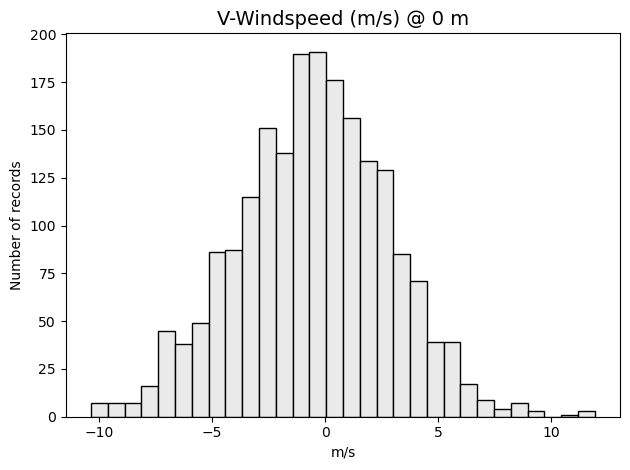

In [22]:
var = ['VGRD_m/s_0_m']
name = 'V-Windspeed (m/s) @ 0 m'
units = 'm/s'
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(df[var], bins=30, color='#eaeaea', edgecolor='black')
ax.set_title(name, fontsize=14)
ax.set_xlabel(units)
ax.set_ylabel("Number of records")
plt.show()

